# Computing Finite Size Lyapunov Exponent from Ocean Parcels

## General Info
#### Author

    Eugenio Cutolo, e.cutolo@imedea.uib-csic.es (IMEDEA)

#### Context

    Work done in collaboration with the SOCIB Modelling Facility

#### Purpose

    Write an efficent python module for computing the alfa and beta coefficents with different equations of
    state of the sea water and then the Brunt Vaisala frequency.
    Starting poin is an xarray containg temperature and salinity from NEMO (or ROMS) outputs.


#### Todo and Remarks
    - Use the internal Ocean Parcel function to remove the particle once the the finite size it is reached

    
## Terms of use and code sharing
This code is under Creative Commons Attribution-ShareAlike 4.0 International license (CC BY-SA 4.0).


You are free to:

  - Share — copy and redistribute the material in any medium or format
  - Adapt — remix, transform, and build upon the material
    for any purpose, even commercially.

Under the following terms:

 - Attribution — You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.

 - ShareAlike — If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original. 

## Code Procedure

- Define initial and final distances $d_0$ and $d_f$
- Setup a regular grid of initial conditions with grid spacing  $d_0$
- Release particles from initial conditions and track trajectories 
- Calculate time $t$ until interparticle separation reaches $d_f$
- Compute 1/t*log($d_f$/ $d_0$) at each initial location

## Code

In [1]:
import xarray as xr
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as dtr

In [3]:
import sys
sys.path.append("/home/ecutolo/Workdir/personal_libraries/")

from usefull_functions import *
from wmop_basic import *

In [4]:
def get_neighbour_indexs(nx,ny):
    x_c,y_c = np.mgrid[0:nx:1,0:ny:1]
    neighbours = np.tile(np.arange(nx*ny),(4,1)).transpose()
    for p_n in np.arange(nx*ny):
        i=x_c.ravel()[p_n]
        j=y_c.ravel()[p_n]
        nn_coords = []
        if i>0: neighbours[p_n][0] = (p_n-ny)
        if i<nx-1: neighbours[p_n][1] = (p_n+ny)
        if j>0: neighbours[p_n][2] = (p_n-1)
        if j<ny-1: neighbours[p_n][3] = (p_n+1)
    return neighbours.ravel()

In [5]:
from numba import njit,vectorize, float64, prange

@njit
def haversine_distance_n(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination

    radius = 6371  # km

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = (np.sin(dlat / 2) * np.sin(dlat / 2) +
         np.cos(np.radians(lat1)) *
         np.cos(np.radians(lat2)) *
         np.sin(dlon / 2) * np.sin(dlon / 2))
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = radius * c

    return d

@njit(parallel=True)
def compute_fsle(particles_lat,particles_lon,neighbours_indexs,DF,DI,DT=1):
    particles_n,times_n = particles_lat.shape
    fsle = np.ones((particles_n))*np.nan
    for p_n in prange(particles_n):
        for t in np.arange(times_n):
            origin_coord = (particles_lat[p_n,t],particles_lon[p_n,t])
            ni = neighbours_indexs[4*p_n:(p_n+1)*4]
            for n in np.arange(4):
                neighbour_coord = (particles_lat[ni[n],t],particles_lon[ni[n],t])
                d = haversine_distance_n(origin_coord,neighbour_coord)
                if d > DF:
                    fsle[p_n] = 1/(t*DT)*np.log(DF/DI)
                    break
            if d > DF: break
    return fsle

/data/ecutolo/miniforge3/lib/python3.8/site-packages/numba/core/decorators.py:252: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [20]:
'''INSERT PARCEL OUTPUT FILE HERE'''
parcels_file =  '/data/ecutolo/particle_tests/WMOPv2.0_CTD_REANALYSIS/p_from_2018-05-20_days_-14_di_2500.nc'

In [21]:
sim_ds = xr.open_dataset(parcels_file)

Plot the initial position of the particles

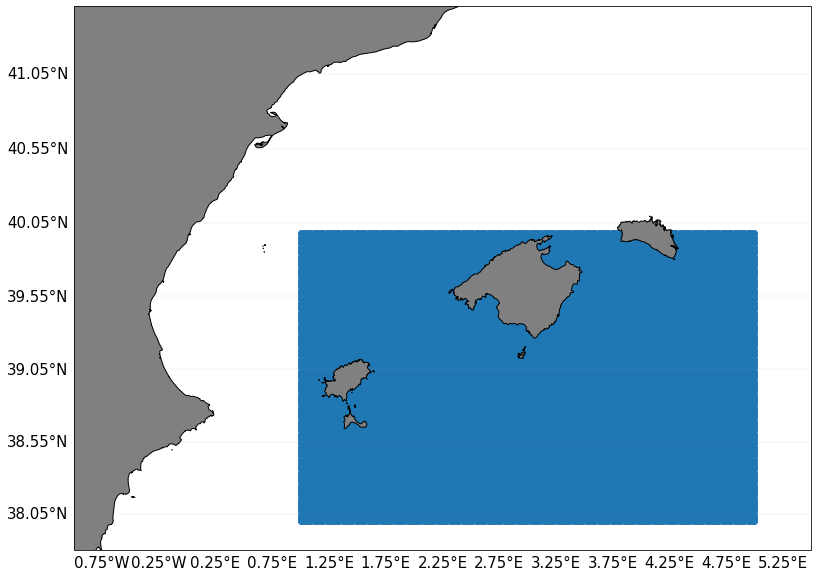

In [22]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
draw_background_map('BalearicIslands', ax=ax)

ax.scatter(sim_ds.isel(obs=0).lon,sim_ds.isel(obs=0).lat,
           transform=dtr())

Plot the final position of the particles

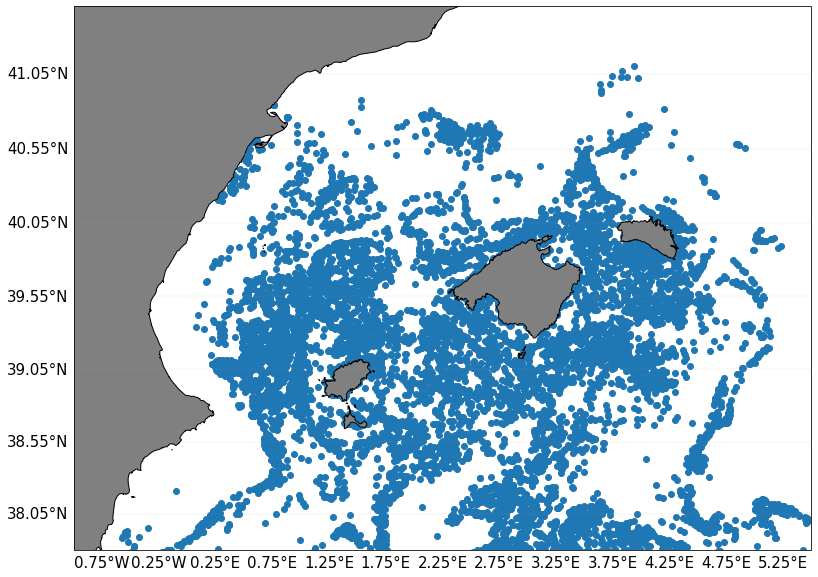

In [23]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
draw_background_map('BalearicIslands', ax=ax)

ax.scatter(sim_ds.lon.isel(obs=-1),sim_ds.lat.isel(obs=-1),
           transform=dtr())

Get some info about the advections

In [24]:
nx = np.unique(sim_ds.isel(obs=0).lon).shape[0]
ny = np.unique(sim_ds.isel(obs=0).lat).shape[0]

In [25]:
neighbours_indexs = get_neighbour_indexs(nx,ny)

In [26]:
timestep = sim_ds.time.diff('obs')[0,0].values/np.timedelta64(1, 'D')

In [27]:
time_direction=np.sign(timestep)

Compute the FSLE

In [28]:
FSLE = compute_fsle(sim_ds.lat.values,sim_ds.lon.values,
                    neighbours_indexs,15,2.5,time_direction*timestep)
FSLE = FSLE.reshape((nx,ny))

Plot the result FSLE

In [29]:
lon,lat = sim_ds.isel(obs=0).lon.values,sim_ds.isel(obs=0).lat.values
lon = lon.reshape((nx,ny))
lat = lat.reshape((nx,ny))

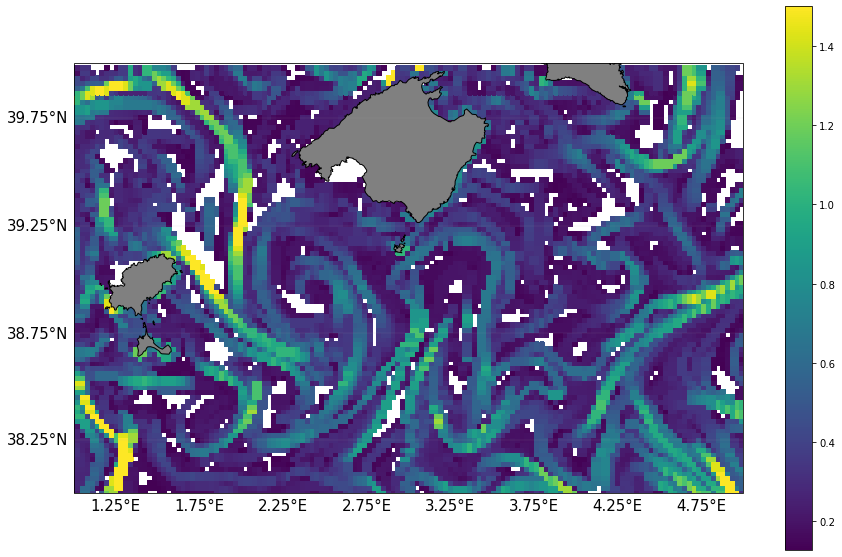

In [33]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
draw_background_map('BalearicIslands2', ax=ax)


sc =ax.pcolormesh(lon,lat,FSLE,transform=dtr(),vmax=1.5)

fig.colorbar(sc)